 <div style="text-align:center;">
   <span style="color:green; font-size:2em; font-weight:bold;">Exploratory Data Analysis (EDA)</span><br><br>
</div>


# <span style="color:green; text-align:center;">Introduction</span>

Dans cette partie, nous nous intéressons à la visualisation des données ainsi qu'à l'analyse descriptive du jeu de données **"final_data"** obtenu suite au nettoyage des bases de données initiales du fichier "Préparation_données.ipynb". <br>

- Pour étudier les tendances moyennes, nous allons se concentrer uniquement sur les observations de la période s'étallant de **2019** à **2023**. Nous voulons à partir de cela visualiser les niveaux moyens de chomage et de croissance économique pour les cinq dernières années. <br>

- Pour les autres représentations, la période considérée est celle s'étallant de **1994** à **2023**. <br>

Pour cela, quatres applications ont été créées.

In [1]:
# Import des packages
from importlib import reload
import declarations as d
reload(d)

<module 'declarations' from 'c:\\Projet-Python\\monmodule\\declarations.py'>

In [2]:
# Importation du jeu de données
df = d.pd.read_csv("./bases/final_data.csv")

In [3]:
# Visualisation 
df.head()

,YEAR,COUNTRY,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,1994-01,AUS,9.814137,0.501645,77.878049,0.963092
1,1994-01,SVN,14.650000,0.748256,73.404878,-0.115694
2,1994-01,CAN,10.700000,0.680429,77.871707,1.095258
3,1994-01,AUT,6.609708,0.779464,76.419512,0.384870
4,1994-01,PHL,9.450000,0.329061,67.942000,2.343515


## <span style="color:green; text-align:center;">I- Présentation de la base</span>

In [4]:
# Dimensions de la DF
df.shape

(3627, 6)

In [5]:
# Informations sur la DF (nombre de valeurs non nulles, type de données de chaque colonne...)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3627 entries, 0 to 3626
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   YEAR               3627 non-null   object 
 1   COUNTRY            3627 non-null   object 
 2   Unemployment_rate  3627 non-null   float64
 3   GDP_rate           3393 non-null   float64
 4   life_expentancy    3277 non-null   float64
 5   pop_growth_rate    3277 non-null   float64
dtypes: float64(4), object(2)
memory usage: 170.1+ KB


In [6]:
# Générer des statistiques descriptives récapitulatives d'une DataFrame
df.describe()

,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
count,3627.000000,3393.000000,3277.000000,3277.000000
mean,7.641700,0.953404,77.805258,0.483831
std,3.810740,0.673057,4.124382,0.889267
min,1.400000,0.016733,64.467073,-6.187253
25%,4.950000,0.747568,75.412195,0.029112
50%,7.066667,0.896520,78.631707,0.399943
75%,9.408281,1.007932,81.078049,0.964254
max,26.366667,8.370481,84.560000,5.321517


In [7]:
# Telécharger le shapefile
world = d.gpd.read_file(d.gpd.datasets.get_path('naturalearth_lowres'))

# Transformer les coordonnées géographiques en coordonnées projetées
world.to_crs('EPSG:4326') 

# Renommer la colonne iso_a3
world=world.rename(columns={'iso_a3': 'COUNTRY'})

C:\Users\yousr\AppData\Local\Temp\ipykernel_17060\4069507274.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = d.gpd.read_file(d.gpd.datasets.get_path('naturalearth_lowres'))


In [8]:
# Visualisation
world.head()

,pop_est,continent,name,COUNTRY,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [9]:
# Sélectionner certaines colonnes
columns_to_keep = ['geometry', 'name','COUNTRY', 'continent']
world = world[columns_to_keep]

# Fusionner les deux DataFrames
world_df = d.pd.merge(world, df, how='inner', on=['COUNTRY'])

In [10]:
# Visualisation
world_df.head()

,geometry,name,COUNTRY,continent,YEAR,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,CAN,North America,1994-01,10.700000,0.680429,77.871707,1.095258
1,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,CAN,North America,1994-02,10.866667,0.680180,77.871707,1.095258
2,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,CAN,North America,1994-03,10.366667,0.686270,77.871707,1.095258
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,CAN,North America,1994-04,10.150000,0.689810,77.871707,1.095258
4,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,CAN,North America,1995-01,9.550000,0.694571,77.977317,1.034769


## <span style="color:green; text-align:center;">II- Visualisation des données </span>

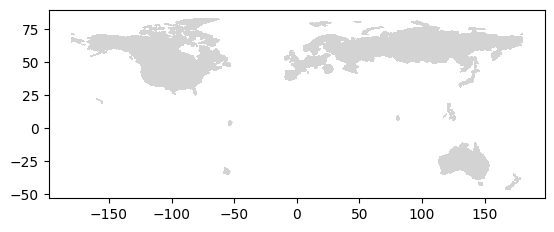

In [11]:
# Plot
world_df.plot(color='lightgrey')
d.plt.show()

## <span style="color:green; text-align:center;">II-1. APPLICATION 1</span>

La première application consiste à créer une application web interactive affichant une carte choroplèthe basée sur les données fournies dans le DataFrame world_df (shapefile).

In [12]:
# Créer un Dash app
app1 = d.dash.Dash(__name__)

# Définir le layout 
app1.layout = d.html.Div([
    # Sélecteur d'année
    d.dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': year, 'value': year} for year in sorted(world_df['YEAR'].unique())],
        value=world_df['YEAR'].min(),  #valeur par defaut de l'année
        multi=False,
    ),
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par défaut de la variable representée
        multi=False,
    ),
    d.dcc.Graph(id='choropleth-map'),
])

# Définir un callback  pour mettre à jour la carte sur l'année selectionnée 
@app1.callback(
    d.Output('choropleth-map', 'figure'),
    [d.Input('year-dropdown', 'value'),
     d.Input('variable-dropdown', 'value')]
)
def update_map(selected_year, selected_variable):
    subset_gdf = world_df[world_df['YEAR'] == selected_year]
    subset_gdf.index = subset_gdf['name']
    fig = d.px.choropleth(
        subset_gdf,
        geojson=subset_gdf.geometry,
        locations=subset_gdf.index,
        color=selected_variable,
        projection="natural earth",
        title=f'{selected_variable} in {selected_year}',
    )
    fig.update_geos(fitbounds="locations", visible=True)
  
    fig.update_layout ( margin = { "r" : 0 , "t" : 0 , "l" : 0 , "b" : 0 }) 
    
    return fig

# Exécuter l'application
if __name__ == '__main__':
    app1.run_server(debug=True, port=8050)

## <span style="color:green; text-align:center;">II-2 APPLICATION 2 : Visualisation des séries temporelles par contient</span>

La deuxième application consiste à créer une application web interactive affichant les plots des séries temporelles des différents indicateurs pour différents pays.

In [13]:
# Créer un Dash app
app2 = d.dash.Dash(__name__)

# Créer le graphique initial
fig = d.px.line(world_df, x='YEAR', y=["Unemployment_rate"], color='name')

# Créer la mise en page de votre application Dash
app2.layout = d.html.Div([
    # Sélecteur de continents
    d.dcc.Dropdown(
        id='continent-selector',
        options=[
            {'label': continent, 'value': continent}
            for continent in world_df['continent'].unique()
        ],
        multi=True,
        value=world_df['continent'].unique()  # Sélectionner tous les continents par défaut
    ),
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # Valeur par defaut de la variable representée
        multi=False,
    ),
    
    # Graphique
    d.dcc.Graph(
        id='line-chart',
        figure=fig
    )
])

# Définir la logique de la mise à jour du graphique en fonction de la sélection du sélecteur
@app2.callback(
    d.Output('line-chart', 'figure'),
    [d.Input('variable-dropdown', 'value'),
     d.Input('continent-selector', 'value')]
)
def update_graph2(selected_variable, selected_continents):
    filtered_df = world_df[world_df['continent'].isin(selected_continents)]
    fig = d.px.line(filtered_df, x='YEAR', y=[selected_variable], color='name',
                   labels={'YEAR': 'Année', selected_variable : f"{selected_variable}"})
    
    
    return fig


# Exécuter l'application Dash
if __name__ == '__main__':
    app2.run_server(debug=True, port=8051)

## <span style="color:green; text-align:center;">II-3 APPLICATION 3 : Visualisation de la tendance moyenne </span>

La troisième application consiste à créer une application web interactive affichant les barplots (diagramme à barres) des valeurs moyennes des différents indicateurs pour les différents pays.

In [14]:
# Tronquer la DataFrame pour garder uniquement les lignes à partir de 2019
df_tronque = world_df.loc[world_df.YEAR >= '2019']

# Sélectionner uniquement les 4 colonnes 'Unemployment_rate', 'GDP_rate', 'life_expentancy' et 'pop_growth_rate', puis faire la moyenne dans chaque groupe
df_group = df_tronque.groupby('name')[
    ['Unemployment_rate', 'GDP_rate', 'life_expentancy', 'pop_growth_rate']
    ].mean().reset_index()

In [15]:
# Visualisation
df_group.head()

,name,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,Australia,5.063088,1.029390,83.146154,0.972761
1,Austria,7.857682,1.116826,81.426642,0.472183
2,Belgium,5.699012,1.125821,81.554784,0.491413
3,Bulgaria,5.739069,1.344580,73.281238,-1.127941
4,Canada,6.985294,1.174125,82.198471,1.089599


In [16]:
# Créer un Dash app
app3 = d.dash.Dash(__name__)

# Créer votre graphique initial
fig = d.px.bar(df_group, x='name', y='Unemployment_rate', color='name',
             labels={'name': 'Pays', 'Unemployment_rate': 'Taux de chômage moyen'},
             template='plotly_dark')

# Créer la mise en page de votre application Dash
app3.layout = d.html.Div([
    
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par défaut de la variable representée
        multi=False,
    ),
    
    # Graphique
    d.dcc.Graph(
        id='bar',
        figure=fig
    )
])

# Définir la logique de la mise à jour du graphique en fonction de la sélection du sélecteur
@app3.callback(
    d.Output('bar', 'figure'),
    [d.Input('variable-dropdown', 'value')]
)
def update_graph3(selected_variable):
    #fig = px.line(filtered_df, x='YEAR', y=["Unemployment_rate"], color='COUNTRY')
    fig = d.px.bar(df_group, x='name', y=[selected_variable], color='name',
                   labels={'name': 'Pays', selected_variable: selected_variable},
                   template='plotly_dark')
    # Afficher le graphique interactif
    
    return fig


# Exécuter l'application Dash
if __name__ == '__main__':
    app3.run_server(debug=True, port=8052)

# <span style="color:green; text-align:center;">III- Analyse descriptive </span>

Pour l'analyse des séries temporelles, une fonction est définie dans le fichier 'declarations.py'. Ladite fonction 'analyse_serie_temporelle_pays' prend en arguments, le jeu de données, l'indicateur (taux de chômage, taux de croissance...) et le pays à considérer.

Cette dernière renvoie, le plot :<br>

<div style="margin-left: 20px;">
-de la série temporelle brute, <br>
-de la série temporelle lissée par une moyenne mobile d'ordre 4,<br> 
-de la décomposition de la série temporelle en composante saisonnière, composante tendancielle et rédisuelle. <br>
    </div>

Enfin, elle permet de tester la stationnarité de la série (Augmented Dickey-Fuller test).<br>

<u>**RAPPEL :**</u>

**Hypothèses du Test de Dickey-Fuller Augmenté (ADF)**

<div style="margin-left: 20px;">

- **$H_0$ :** La série temporelle a une racine unitaire, ce qui indique la non-stationnarité.

- **$H_1$ :** La série temporelle n'a pas de racine unitaire, ce qui indique la stationnarité.
    </div>
**Interprétation des résultats :**

<div style="margin-left: 20px;">

- Si la statistique du test est inférieure à la valeur critique au seuil de signification (par exemple, 0.05), on aurait tendance à rejeter l'hypothèse nulle et conclure que la série temporelle est stationnaire.<br>

- Sinon, on ne peut pas rejeter l'hypothèse nulle, ce qui suggère que la série temporelle est non stationnaire.
    </div>

**NB :** Le test est implémenté par la bibliothèque Statsmodels de Python.


### <span style="color:green; text-align:center;">III-1. Série temporelle : Taux de chômage </span>

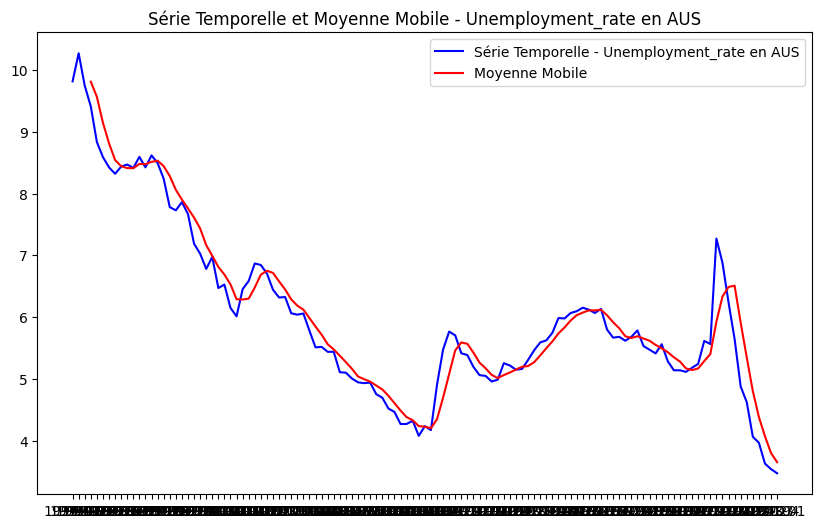

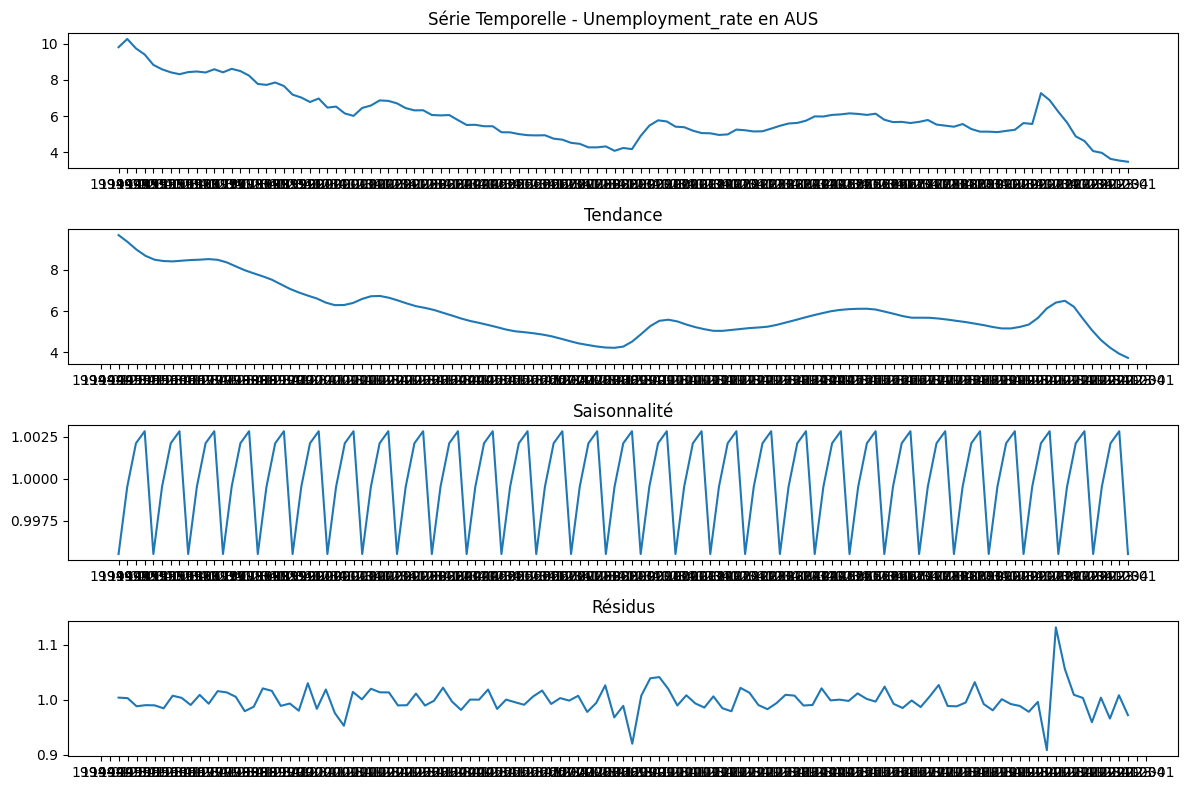

Test de Dickey-Fuller Augmenté:
Statistique de test = -2.3413229556734803
Valeur critique (5%) = -2.887246327182993


In [17]:
# EXEMPLE : Utilisation de la fonction avec le DataFrame 'final_data', le pays 'AUS', et la variable 'Unemployment_rate'
d.analyse_serie_temporelle_pays(df,'Unemployment_rate', 'AUS')

### <span style="color:green; text-align:center;">III-2. Série temporelle : Taux de croissance du PIB </span>

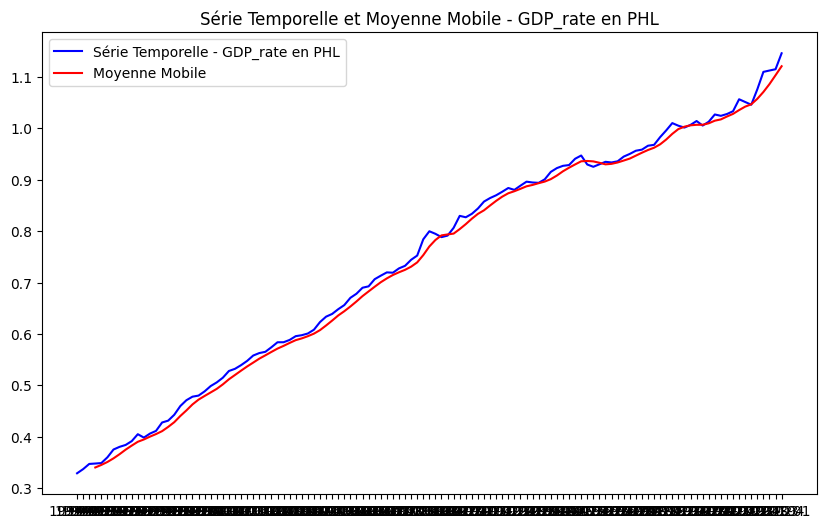

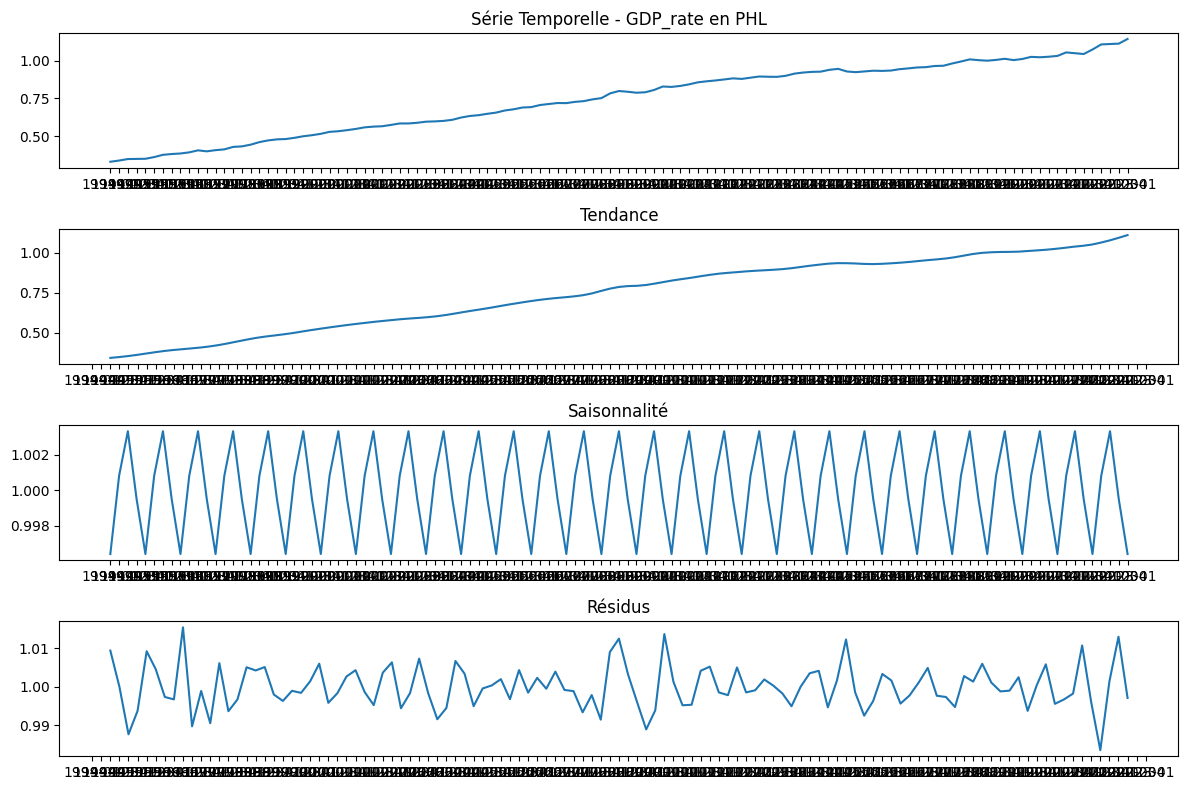

Test de Dickey-Fuller Augmenté:
Statistique de test = -0.5713193563243522
Valeur critique (5%) = -2.8879516565798817


In [18]:
# EXEMPLE : Utilisation de la fonction avec le DataFrame 'final_data', le pays 'PHL', et la variable 'GDP_rate'
d.analyse_serie_temporelle_pays(df,'GDP_rate', 'PHL')

### <span style="color:green; text-align:center;">III-3. Série temporelle : Croissance démographique </span>

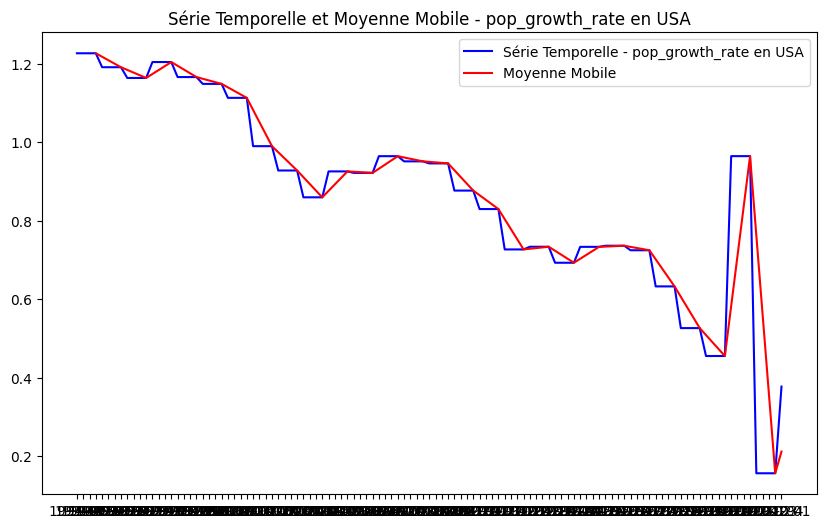

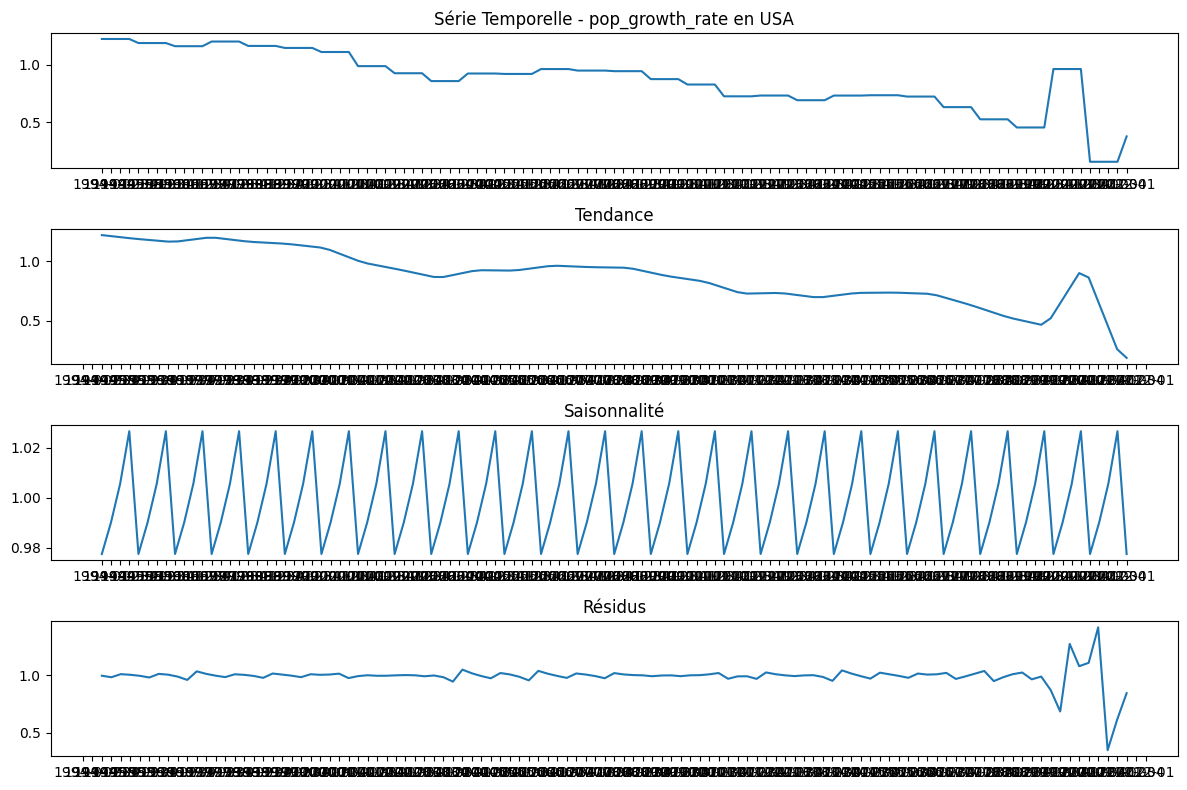

Test de Dickey-Fuller Augmenté:
Statistique de test = -0.12804497873453227
Valeur critique (5%) = -2.889758398668639


In [19]:
# EXEMPLE : Utilisation de la fonction avec le DataFrame 'final_data', le pays 'PHL', et la variable 'GDP_rate'
d.analyse_serie_temporelle_pays(df,'pop_growth_rate', 'USA')

### <span style="color:green; text-align:center;">III-4. Série temporelle : Espérance de vie </span>

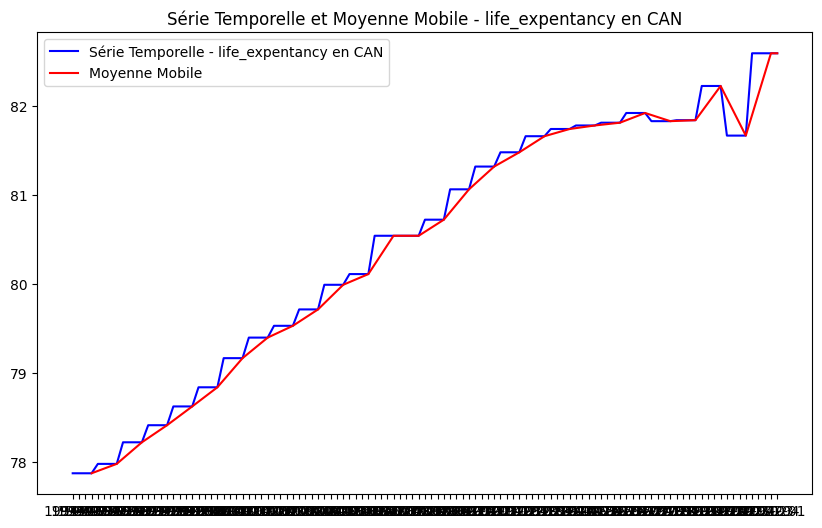

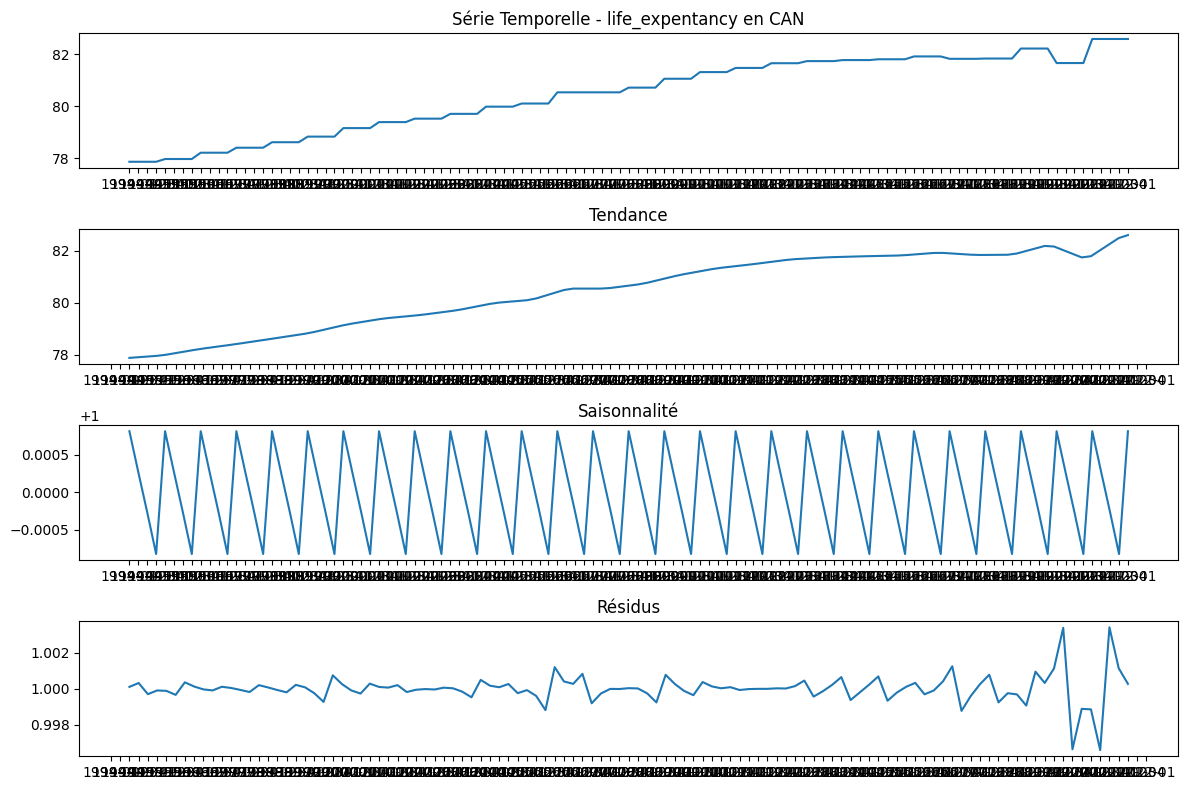

Test de Dickey-Fuller Augmenté:
Statistique de test = -1.5013810010116992
Valeur critique (5%) = -2.89090644


In [20]:
# EXEMPLE : Utilisation de la fonction avec le DataFrame 'final_data', le pays 'PHL', et la variable 'GDP_rate'
d.analyse_serie_temporelle_pays(df,'life_expentancy', 'CAN')

## <span style="color:green; text-align:center;">III-5. APPLICATION 4 : </span>

Dans ce qui suit, la fonction 'analyse_serie_temporelle_pays' sera implémentée dans une application dash.

In [21]:
df=world_df.copy()

In [22]:
# Créer un Dash app
app = d.dash.Dash(__name__)

# Liste des pays disponibles dans le dataframe
pays_disponibles = df['name'].unique()

app.layout = d.html.Div([
    d.html.H1("Analyse de Série Temporelle"),
    
    
   # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par defaut de la variable representée
        multi=False,
    ),
    
    
    # Sélection du pays
    d.html.Label("Choisissez le pays :"),
    d.dcc.Dropdown(
        id='dropdown-pays',
        options=[
            {'label': pays, 'value': pays} for pays in pays_disponibles
        ],
        value=pays_disponibles[0]
    ),
    
    # Graphiques
    d.dcc.Graph(id='time-series-plot'),
    d.dcc.Graph(id='decomposition-plot'),
])

@app.callback(
    [d.Output('time-series-plot', 'figure'),
     d.Output('decomposition-plot', 'figure')],
    [d.Input('variable-dropdown', 'value'),
     d.Input('dropdown-pays', 'value')]
)
def update_graph(indicateur, pays):
    # Sélectionner la série temporelle du pays spécifique
    serie_temporelle = df[indicateur].dropna()
    
    # Moyenne mobile d'ordre 4
    rolling_mean = serie_temporelle.rolling(window=4).mean()

    # Créer le premier graphique (série temporelle et moyenne mobile)
    time_series_fig = d.px.line(x=serie_temporelle.index, y=[serie_temporelle, rolling_mean],
                              labels={'variable': 'Type', 'value': 'Valeur'},
                              title=f'Série Temporelle et Moyenne Mobile - {indicateur} en {pays}',
                              color_discrete_map={'0': 'blue', '1': 'red'})
    
    # Décomposition saisonnière
    decomposition = d.seasonal_decompose(serie_temporelle, model='multiplicative', period=4)

    # Créer le deuxième graphique (décomposition)
    decomposition_fig = d.px.line(x=serie_temporelle.index, y=[decomposition.trend, decomposition.seasonal, decomposition.resid],
                                labels={'variable': 'Composant', 'value': 'Valeur'},
                                title=f'Décomposition - {indicateur} en {pays}',
                                color_discrete_map={'0': 'green', '1': 'orange', '2': 'gray'})

    return time_series_fig, decomposition_fig

if __name__ == '__main__':
    app.run_server(debug=True)